# [NTDS'19] assignment 1: network science
[ntds'19]: https://github.com/mdeff/ntds_2019

[Eda Bayram](https://lts4.epfl.ch/bayram), [EPFL LTS4](https://lts4.epfl.ch) and
[Nikolaos Karalias](https://people.epfl.ch/nikolaos.karalias), [EPFL LTS2](https://lts2.epfl.ch).

## Students

* Team: `04`
* Students: `Yann BOUQUET` (for the indivudual submission) or `<the name of all students in the team>` (for the team submission)

## Rules

Grading:
* The first deadline is for individual submissions. The second deadline is for the team submission.
* All team members will receive the same grade based on the team solution submitted on the second deadline.
* As a fallback, a team can ask for individual grading. In that case, solutions submitted on the first deadline are graded.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

Submission:
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
  Note that Networkx is imported in the second section and cannot be used in the first.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter.

## Objective

The purpose of this milestone is to explore a given dataset, represent it by network by constructing different graphs. In the first section, you will analyze the network properties. In the second section, you will explore various network models and find out the network model fitting the ones you construct from the dataset.

## Cora Dataset

The [Cora dataset](https://linqs.soe.ucsc.edu/node/236) consists of scientific publications classified into one of seven research fields. 

* **Citation graph:** the citation network can be constructed from the connections given in the `cora.cites` file.
* **Feature graph:** each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary and its research field, given in the `cora.content` file. The dictionary consists of 1433 unique words. A feature graph can be constructed using the Euclidean distance between the feature vector of the publications.

The [`README`](data/cora/README) provides details about the content of [`cora.cites`](data/cora/cora.cites) and [`cora.content`](data/cora/cora.content).

## Section 1: Network Properties

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

### Question 1: Construct a Citation Graph and a Feature Graph

Read the `cora.content` file into a Pandas DataFrame by setting a header for the column names. Check the `README` file.

In [3]:
n_words = 1433
column_list = []
column_list.append('paper_id')
for i in range(n_words):
    column_list.append('word_attributes_' + str(i))
column_list.append('class_label')
pd_content = pd.read_csv('data/cora/cora.content', delimiter='\t', names=column_list) 
pd_content.head()

,paper_id,word_attributes_0,word_attributes_1,word_attributes_2,word_attributes_3,word_attributes_4,word_attributes_5,word_attributes_6,word_attributes_7,word_attributes_8,...,word_attributes_1424,word_attributes_1425,word_attributes_1426,word_attributes_1427,word_attributes_1428,word_attributes_1429,word_attributes_1430,word_attributes_1431,word_attributes_1432,class_label
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


Print out the number of papers contained in each of the reasearch fields.

**Hint:** You can use the `value_counts()` function.

In [4]:
pd_content.class_label.value_counts()

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: class_label, dtype: int64

Select all papers from a field of your choice and store their feature vectors into a NumPy array.
Check its shape.

In [5]:
my_field = 'Theory'
features = pd_content.loc[pd_content.class_label == my_field, pd_content.columns.array[1:n_words+1]].values
features.shape

(351, 1433)

Let $D$ be the Euclidean distance matrix whose $(i,j)$ entry corresponds to the Euclidean distance between feature vectors $i$ and $j$.
Using the feature vectors of the papers from the field which you have selected, construct $D$ as a Numpy array. 

In [6]:
n = features.shape[0]
distance = np.zeros([n,n])
for i in range(n):
    for j in range(n-i):
        diff = features[i] - features[j+i]
        distance[i, j+i] = np.sqrt(np.sum(diff * diff, axis = 0))
        distance[j+i, i] = distance[i, j+i]
distance.shape

(351, 351)

Check the mean pairwise distance $\mathbb{E}[D]$.

In [7]:
mean_distance = distance.mean()
mean_distance

5.748216300560453

Plot an histogram of the euclidean distances.

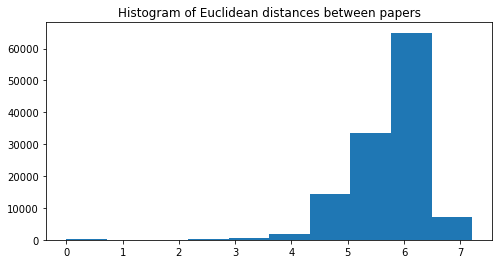

In [8]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between papers")
plt.hist(distance.flatten());

Now create an adjacency matrix for the papers by thresholding the Euclidean distance matrix.
The resulting (unweighted) adjacency matrix should have entries
$$ A_{ij} = \begin{cases} 1, \; \text{if} \; d(i,j)< \mathbb{E}[D], \; i \neq j, \\ 0, \; \text{otherwise.} \end{cases} $$

First, let us choose the mean distance as the threshold.

In [9]:
threshold = mean_distance
A_feature = (distance < mean_distance).astype(int)
for i in range(n):
    A_feature[i, i] = 0

Now read the `cora.cites` file and construct the citation graph by converting the given citation connections into an adjacency matrix.

In [10]:
cora_cites = np.genfromtxt('data/cora/cora.cites', delimiter='\t')

n_nodes = len(pd_content)
A_citation =np.zeros([n_nodes, n_nodes])

for cited, citing in cora_cites:
    A_citation[\
        pd_content[pd_content.paper_id == citing].index[0],\
               pd_content[pd_content.paper_id == cited].index[0]\
    ] += 1
    
A_citation.shape

(2708, 2708)

Get the adjacency matrix of the citation graph for the field that you chose.
You have to appropriately reduce the adjacency matrix of the citation graph.

In [11]:
my_field_idx = [idx for idx in pd_content[pd_content.class_label == my_field].index]
A_citation = A_citation[my_field_idx, :][:, my_field_idx]
A_citation.shape

(351, 351)

Check if your adjacency matrix is symmetric. Symmetrize your final adjacency matrix if it's not already symmetric.

In [12]:
A_citation = A_citation + A_citation.T - np.diag(A_citation)
np.count_nonzero(A_citation - A_citation.transpose())

0

Check the shape of your adjacency matrix again.

In [13]:
A_citation.shape

(351, 351)

### Question 2: Degree Distribution and Moments

What is the total number of edges in each graph?

In [14]:
num_edges_feature = np.count_nonzero(A_feature) / 2
num_edges_citation = np.count_nonzero(A_citation) / 2
print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 25321.0
Number of edges in the citation graph: 534.0


Plot the degree distribution histogram for each of the graphs.

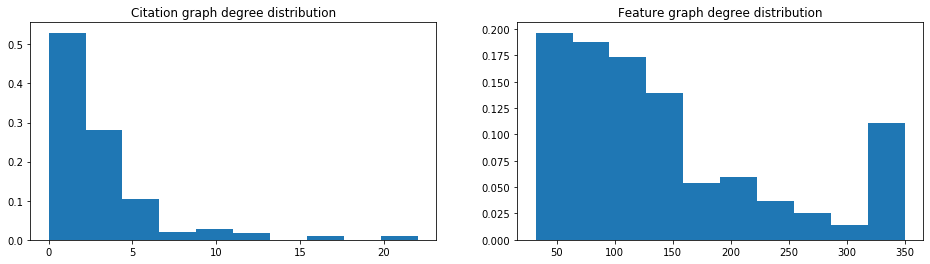

In [15]:
degrees_citation = np.sum(A_citation, axis = 0)
degrees_feature = np.sum(A_feature, axis = 0)

deg_hist_normalization = np.ones(degrees_citation.shape[0]) / degrees_citation.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(degrees_citation, weights=deg_hist_normalization);
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(degrees_feature, weights=deg_hist_normalization);

Calculate the first and second moments of the degree distribution of each graph.

In [16]:
cit_moment_1 = degrees_citation.mean()
cit_moment_2 = (np.power(degrees_citation,2)).mean()

feat_moment_1 = degrees_feature.mean()
feat_moment_2 = (np.power(degrees_feature, 2)).mean()

print(f"1st moment of citation graph: {cit_moment_1}")
print(f"2nd moment of citation graph: {cit_moment_2}")
print(f"1st moment of feature graph: {feat_moment_1}")
print(f"2nd moment of feature graph: {feat_moment_2}")

1st moment of citation graph: 3.1794871794871793
2nd moment of citation graph: 19.72079772079772
1st moment of feature graph: 144.27920227920228
2nd moment of feature graph: 29639.094017094016


What information do the moments provide you about the graphs?
Explain the differences in moments between graphs by comparing their degree distributions.

**Your answer here:**

Select the 20 largest hubs for each of the graphs and remove them. Observe the sparsity pattern of the adjacency matrices of the citation and feature graphs before and after such a reduction.

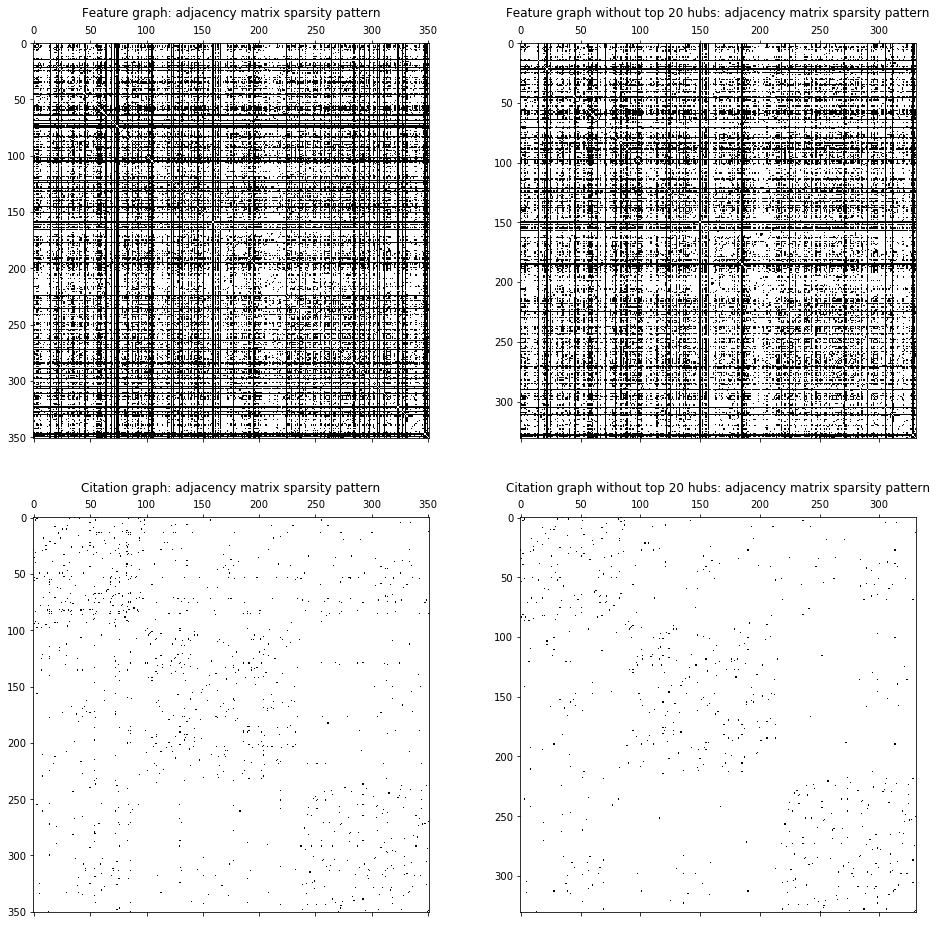

In [17]:
hubs_indices = np.sort(np.argsort(degrees_feature)[:-20])
reduced_A_feature = A_feature[hubs_indices, :][:, hubs_indices]
hubs_indices = np.sort(np.argsort(degrees_citation)[:-20])
reduced_A_citation = A_citation[hubs_indices, :][:, hubs_indices]

fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes[0, 0].set_title('Feature graph: adjacency matrix sparsity pattern')
axes[0, 0].spy(A_feature);
axes[0, 1].set_title('Feature graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[0, 1].spy(reduced_A_feature);
axes[1, 0].set_title('Citation graph: adjacency matrix sparsity pattern')
axes[1, 0].spy(A_citation);
axes[1, 1].set_title('Citation graph without top 20 hubs: adjacency matrix sparsity pattern')
axes[1, 1].spy(reduced_A_citation);

Plot the new degree distribution histograms.

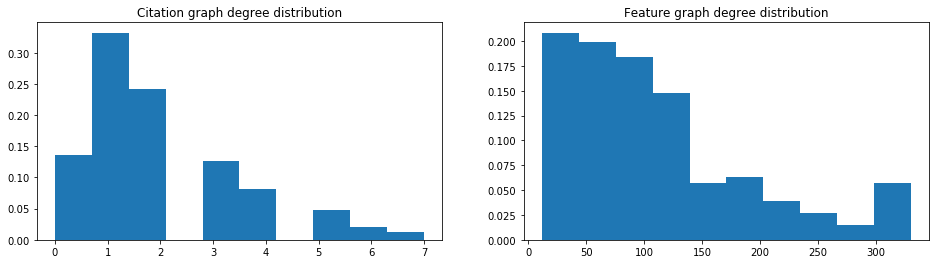

In [18]:
reduced_degrees_feat = np.sum(reduced_A_feature, axis = 0)
reduced_degrees_cit = np.sum(reduced_A_citation, axis = 0)

deg_hist_normalization = np.ones(reduced_degrees_feat.shape[0])/reduced_degrees_feat.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title('Citation graph degree distribution')
axes[0].hist(reduced_degrees_cit, weights=deg_hist_normalization);
axes[1].set_title('Feature graph degree distribution')
axes[1].hist(reduced_degrees_feat, weights=deg_hist_normalization);

Compute the first and second moments for the new graphs.

In [19]:
reduced_cit_moment_1 = reduced_degrees_cit.mean()
reduced_cit_moment_2 = (np.power(reduced_degrees_cit, 2)).mean()

reduced_feat_moment_1 = reduced_degrees_feat.mean()
reduced_feat_moment_2 = (np.power(reduced_degrees_feat, 2)).mean()


print("Citation graph first moment:", reduced_cit_moment_1)
print("Citation graph second moment:", reduced_cit_moment_2)
print("Feature graph first moment: ", reduced_feat_moment_1)
print("Feature graph second moment: ", reduced_feat_moment_2)

Citation graph first moment: 1.9758308157099698
Citation graph second moment: 6.308157099697885
Feature graph first moment:  111.8489425981873
Feature graph second moment:  19154.205438066467


Print the number of edges in the reduced graphs.

In [20]:
num_edges_feature = np.count_nonzero(reduced_A_feature) / 2
num_edges_citation = np.count_nonzero(reduced_A_citation) / 2
print(f"Number of edges in the reduced feature graph: {num_edges_feature}")
print(f"Number of edges in the reduced citation graph: {num_edges_citation}")

Number of edges in the reduced feature graph: 18511.0
Number of edges in the reduced citation graph: 310.0


Is the effect of removing the hubs the same for both networks? Look at the percentage changes for each moment. Which of the moments is affected the most and in which graph? Explain why.  

**Hint:** Examine the degree distributions.

**Your answer here:**

### Question 3: Pruning, sparsity, paths

By adjusting the threshold of the euclidean distance matrix, prune the feature graph so that its number of edges is roughly close (within a hundred edges) to the number of edges in the citation graph.

In [21]:
threshold = mean_distance/2

A_feature_pruned = (distance < threshold).astype(int)
for i in range(n):
    A_feature_pruned[i, i] = 0
num_edges_feature_pruned = np.count_nonzero(A_feature_pruned)

print(f"Number of edges in the feature graph: {num_edges_feature}")
print(f"Number of edges in the feature graph after pruning: {num_edges_feature_pruned}")
print(f"Number of edges in the citation graph: {num_edges_citation}")

Number of edges in the feature graph: 18511.0
Number of edges in the feature graph after pruning: 364
Number of edges in the citation graph: 310.0


Check your results by comparing the sparsity patterns and total number of edges between the graphs.

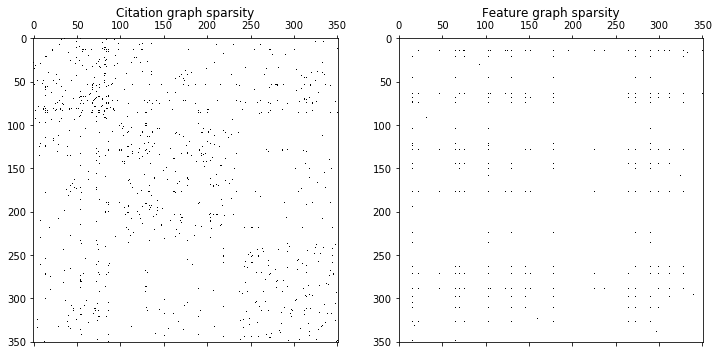

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title('Citation graph sparsity')
axes[0].spy(A_citation);
axes[1].set_title('Feature graph sparsity')
axes[1].spy(A_feature_pruned);

Let $C_{k}(i,j)$ denote the number of paths of length $k$ from node $i$ to node $j$. 

We define the path matrix $P$, with entries
$ P_{ij} = \displaystyle\sum_{k=0}^{N}C_{k}(i,j). $

Calculate the path matrices for both the citation and the unpruned feature graphs for $N =10$.  

**Hint:** Use [powers of the adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix#Matrix_powers).

In [23]:
N = 10
path_matrix_citation = np.eye(A_citation.shape[0])
path_matrix_feature = np.eye(A_feature.shape[0])
for i in range(N):
    path_matrix_citation += path_matrix_citation @ A_citation
    path_matrix_feature += path_matrix_citation @ A_feature

Check the sparsity pattern for both of path matrices.

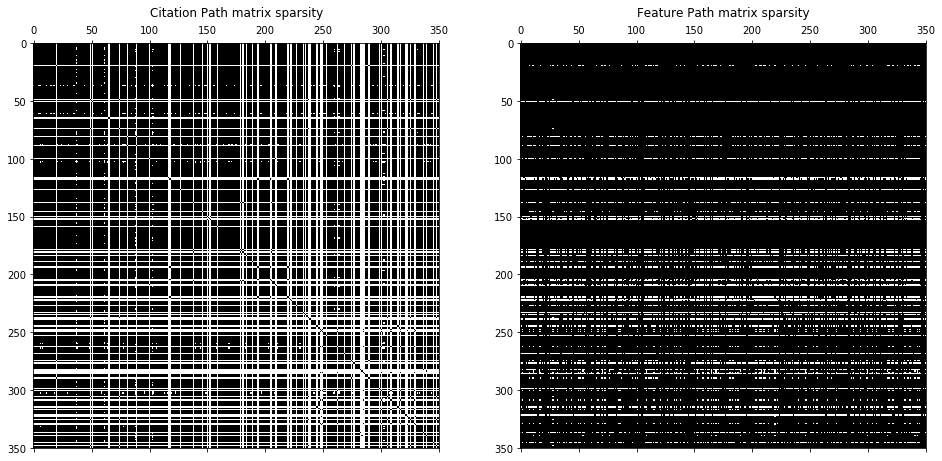

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(16, 9))
axes[0].set_title('Citation Path matrix sparsity')
axes[0].spy(path_matrix_citation);
axes[1].set_title('Feature Path matrix sparsity')
axes[1].spy(path_matrix_feature);

Now calculate the path matrix of the pruned feature graph for $N=10$. Plot the corresponding sparsity pattern. Is there any difference?

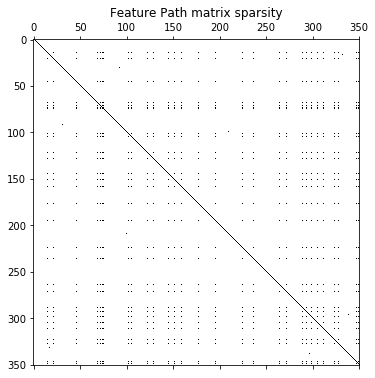

In [25]:
N = 10
path_matrix_pruned = np.eye(A_feature_pruned.shape[0])
for i in range(N):
    path_matrix_pruned += path_matrix_pruned @ A_feature_pruned

plt.figure(figsize=(12, 6))
plt.title('Feature Path matrix sparsity')
plt.spy(path_matrix_pruned);

**Your answer here:**

Describe how you can use the above process of counting paths to determine whether a graph is connected or not. Is the original (unpruned) feature graph connected?

**Your answer here:** 

If the graph is connected, how can you guess its diameter using the path matrix?

**Your answer here:**

If any of your graphs is connected, calculate the diameter using that process.

In [26]:
diameter = # Your code here.
print(f"The diameter is: {diameter}")

SyntaxError: invalid syntax (<ipython-input-26-70a94a21d3fc>, line 1)

Check if your guess was correct using [NetworkX](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.distance_measures.diameter.html).
Note: usage of NetworkX is only allowed in this part of Section 1.

In [ ]:
import networkx as nx
feature_graph = nx.from_numpy_matrix(A_feature)
print(f"Diameter according to networkx: {nx.diameter(feature_graph)}")

## Section 2: Network Models

In this section, you will analyze the feature and citation graphs you constructed in the previous section in terms of the network model types.
For this purpose, you can use the NetworkX libary imported below.

In [27]:
import networkx as nx

Let us create NetworkX graph objects from the adjacency matrices computed in the previous section.

In [28]:
G_citation = nx.from_numpy_matrix(A_citation)
print('Number of nodes: {}, Number of edges: {}'. format(G_citation.number_of_nodes(), G_citation.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_citation.number_of_selfloops(), nx.number_connected_components(G_citation)))

Number of nodes: 351, Number of edges: 534
Number of self-loops: 0, Number of connected components: 36


In the rest of this assignment, we will consider the pruned feature graph as the feature network.

In [29]:
G_feature = nx.from_numpy_matrix(A_feature_pruned)
print('Number of nodes: {}, Number of edges: {}'. format(G_feature.number_of_nodes(), G_feature.number_of_edges()))
print('Number of self-loops: {}, Number of connected components: {}'. format(G_feature.number_of_selfloops(), nx.number_connected_components(G_feature)))

Number of nodes: 351, Number of edges: 182
Number of self-loops: 0, Number of connected components: 317


### Question 4: Simulation with Erdős–Rényi and Barabási–Albert models

Create an Erdős–Rényi and a Barabási–Albert graph using NetworkX to simulate the citation graph and the feature graph you have. When choosing parameters for the networks, take into account the number of vertices and edges of the original networks.

The number of nodes should exactly match the number of nodes in the original citation and feature graphs.

In [30]:
assert len(G_citation.nodes()) == len(G_feature.nodes())
n = len(G_citation.nodes())
n

351

The number of match shall fit the average of the number of edges in the citation and the feature graph.

In [31]:
m = np.round((G_citation.size() + G_feature.size()) / 2)
m

358.0

How do you determine the probability parameter for the Erdős–Rényi graph?

**Your answer here:** The probability p, for the Erdős–Rényi model of any graph, is given by the number of links $m$ of this graph divided by the maximal number of links (unidirectional) possible for the available nodes $n*(n-1)/2$.


In [32]:
p = (2*m)/(n*(n-1))
G_er = nx.erdos_renyi_graph(n, p)

Check the number of edges in the Erdős–Rényi graph.

In [33]:
print('My Erdos-Rényi network that simulates the citation graph has {} edges.'.format(G_er.size()))

My Erdos-Rényi network that simulates the citation graph has 352 edges.


How do you determine the preferential attachment parameter for Barabási–Albert graphs?

**Your answer here:** Preferential attachemnt of a given graph is the tendency (probability) that newly added nodes link to already highly linked nodes (high degree). This probability $\Pi\left(k_{i}\right)$ that a link of the new node connects to node i can thus be given by $\Pi\left(k_{i}\right)=\frac{k_{i}}{\sum_{j} k_{j}}$

In [34]:
q = int(m/n)
G_ba = nx.barabasi_albert_graph(n, q)

Check the number of edges in the Barabási–Albert graph.

In [35]:
print('My Barabási-Albert network that simulates the citation graph has {} edges.'.format(G_ba.size()))

My Barabási-Albert network that simulates the citation graph has 350 edges.


### Question 5: Giant Component

Check the size of the largest connected component in the citation and feature graphs.

In [36]:
giant_citation = max(list(nx.connected_component_subgraphs(G_citation)), key = len)
print('The giant component of the citation graph has {} nodes and {} edges.'.format(giant_citation.number_of_nodes(), giant_citation.size()))

The giant component of the citation graph has 287 nodes and 499 edges.


In [37]:
giant_feature = max(list(nx.connected_component_subgraphs(G_feature)), key = len)
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

The giant component of the feature graph has 31 nodes and 178 edges.


Check the size of the giant components in the generated Erdős–Rényi graph.

In [38]:
giant_er = max(list(nx.connected_component_subgraphs(G_er)), key = len)
print('The giant component of the Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er.number_of_nodes(), giant_er.size()))

The giant component of the Erdos-Rényi network has 283 nodes and 338 edges.


Let us match the number of nodes in the giant component of the feature graph by simulating a new Erdős–Rényi network.
How do you choose the probability parameter this time? 

**Hint:** Recall the expected giant component size from the lectures.

**Your answer here:**

In [64]:
k_mean = np.mean([G_feature.degree(n) for n in G_feature.nodes()])
print(f"<k> = {k_mean:.2f}")
N = np.log(G_feature.size())
print(f"{N:.2f}")

ng = giant_feature.number_of_nodes()
p_new = (-np.log(1-(ng/n)))/((ng/n)*(n))
G_er_new = nx.erdos_renyi_graph(n, p_new)
print(f"p = {p:.6f}, p_new = {p_new:.6f}")

<k> = 1.04
5.20
p = 0.005828, p_new = 0.002983


Check the size of the new Erdős–Rényi network and its giant component.

In [40]:
print('My new Erdos Renyi network that simulates the citation graph has {} edges.'.format(G_er_new.size()))
giant_er_new = max(list(nx.connected_component_subgraphs(G_er_new)), key = len)
print('The giant component of the new Erdos-Rényi network has {} nodes and {} edges.'.format(giant_er_new.number_of_nodes(), giant_er_new.size()))

My new Erdos Renyi network that simulates the citation graph has 204 edges.
The giant component of the new Erdos-Rényi network has 68 nodes and 67 edges.


# Question 6: Degree Distributions

Recall the degree distribution of the citation and the feature graph.

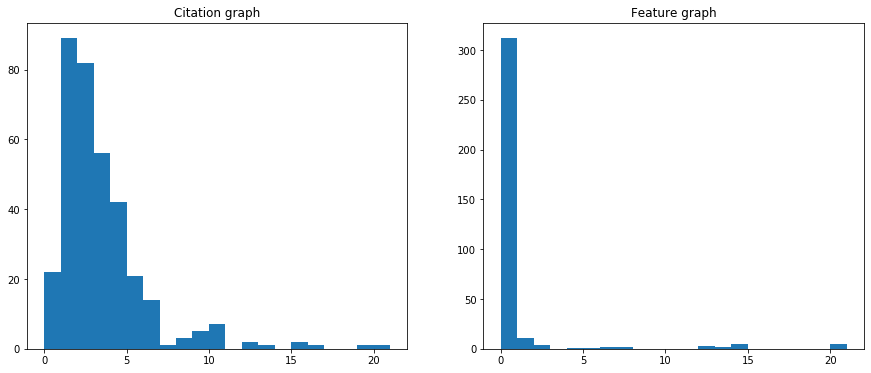

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].set_title('Citation graph')
citation_degrees = [G_citation.degree(n) for n in G_citation.nodes()]
axes[0].hist(citation_degrees, bins = range(min(citation_degrees), max(citation_degrees)));
axes[1].set_title('Feature graph')
feature_degrees = [G_feature.degree(n) for n in G_feature.nodes()]
axes[1].hist(feature_degrees, bins = range(min(citation_degrees), max(citation_degrees)));

Text(0, 0.5, '$p_k$')

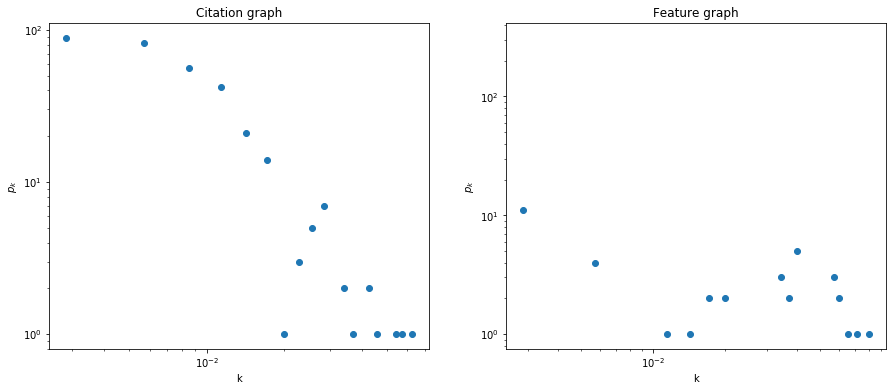

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].set_title('Citation graph')
citation_degrees = [G_citation.degree(n) for n in G_citation.nodes()]
values, counts = np.unique(citation_degrees,return_counts=True)
values = values / len(feature_degrees)
axes[0].plot(values,counts,'o');
axes[1].set_title('Feature graph')
feature_degrees = [G_feature.degree(n) for n in G_feature.nodes()]
values, counts = np.unique(feature_degrees,return_counts=True)
values = values / len(feature_degrees)
axes[1].plot(values,counts,'o');

axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel("k")
axes[0].set_ylabel("$p_k$")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel("k")
axes[1].set_ylabel("$p_k$")

What does the degree distribution tell us about a network? Can you make a prediction on the network model type of the citation and the feature graph by looking at their degree distributions?

**Your answer here:**
The degree distribution seems to follow a power law distribution. So it tells us that the networks fit a scale-free model
definit la power law
//We observe that the degree distribution is mostly zero for both graphs. 
(idée : citation graph, nouveau bouquin cite ancien + hubs = crédibilité)
In the citation graph we mostly observe that nodes have zero degree distribution and 
The scale-free behavior of the citation graph could come from the fact that the books are publihed one at a time and considering that here every book are in the same category, the new ones would cite the older ones (growth property) and the more cited books get a scientific credibility that forces the new publication to refer to them intead of the others (preferential attachment propertiy)


Now, plot the degree distribution historgrams for the simulated networks.

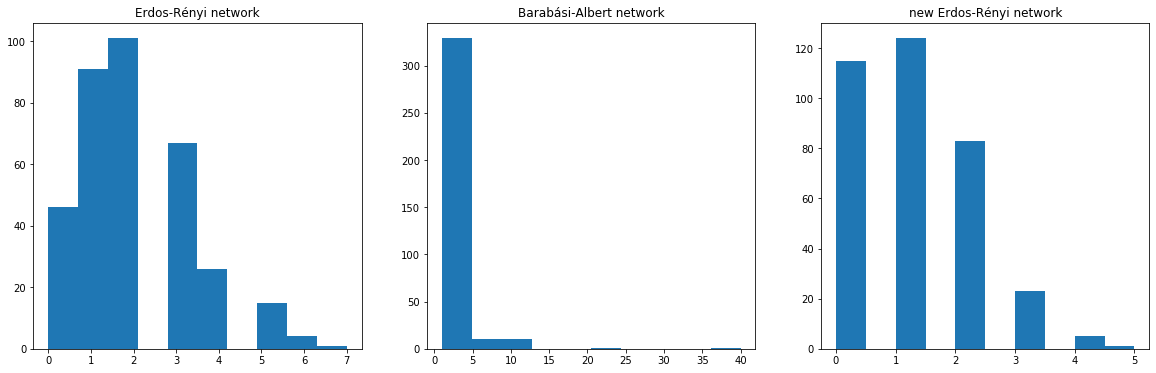

In [60]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].set_title('Erdos-Rényi network')
er_degrees = [G_er.degree(n) for n in G_er.nodes()]
axes[0].hist(er_degrees);
axes[1].set_title('Barabási-Albert network')
ba_degrees = [G_ba.degree(n) for n in G_ba.nodes()]
axes[1].hist(ba_degrees);
axes[2].set_title('new Erdos-Rényi network')
er_new_degrees = [G_er_new.degree(n) for n in G_er_new.nodes()]
axes[2].hist(er_new_degrees);

In terms of the degree distribution, is there a good match between the citation and feature graphs and the simulated networks?
For the citation graph, choose one of the simulated networks above that match its degree distribution best. Indicate your preference below.

**Your answer here:** Contemplating the degree distributions only it seems that the citation graphs degree distribution shows similarities with the simulated Erdos-Rényi network. Whereas the  there is no obvious difference between the new and the Erdos-Rényi network itself except for maybe the anticipated less nodes in the new graph due to the lower $p_{new}$ resulting in a sparser plot. The Barabási-Albert model seems to better fit the feature graph in the sense that it only has very few hubs to connect many low degree nodes with and thus emphasizing the scale-free character of this graph.

You can also simulate a network using the configuration model to match its degree disctribution exactly. Refer to [Configuration model](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html#networkx.generators.degree_seq.configuration_model).

Let us create another network to match the degree distribution of the feature graph. 

In [98]:
G_config = nx.configuration_model(feature_degrees, create_using = nx.Graph) 
print('Configuration model has {} nodes and {} edges.'.format(G_config.number_of_nodes(), G_config.size()))

Configuration model has 351 nodes and 182 edges.


Does it mean that we create the same graph with the feature graph by the configuration model? If not, how do you understand that they are not the same?

**Your answer here:** Even though the new configuration_mode graph follows the same degree distribution of the feature graph, it does not mean that they may represent the same structure of the graph in general. Since the clustering structure or the number of connected components are network characterisations that do not generally depend on the degree distribution. Furthermore we already see that the new graph only has half of the edges the original has and can therefore clearly not be the same.

### Question 7: Clustering Coefficient

Let us check the average clustering coefficient of the original citation and feature graphs. 

In [71]:
c1 = nx.average_clustering(G_citation)
c1

0.19443820911432255

In [72]:
c2 = nx.average_clustering(G_feature)
c2

0.0661347084939697

What does the clustering coefficient tell us about a network? Comment on the values you obtain for the citation and feature graph.

**Your answer here:** The clustering coefficient can be seen as the local (at a chosen node) percentage of how connected the neighboring nodes are. Meaning that for $C_i = 0$ there exists no connection between the ith components neighbors and for $C_i = 1$ all neighboring nodes are connected between each other.

Now, let us check the average clustering coefficient for the simulated networks.

In [46]:
nx.average_clustering(G_er)

0.009686609686609688

In [47]:
nx.average_clustering(G_ba)

0.0

In [48]:
nx.average_clustering(nx.Graph(G_config))

0.03549357323867128

Comment on the values you obtain for the simulated networks. Is there any good match to the citation or feature graph in terms of clustering coefficient?

**Your answer here:** We can see that the clusterin coefficient of the Barabási-Albert model amounts to zero meaning that there are very few connections between the neighbooring nodes on average which might be an indication of some high degree nodes. However, the clustering coefficient of the citation and feature network with $C_{cit} \approx 19\%$ and $C_{feat} \approx 7\%$ are clearly higher than this model. The Erdos-Rényi model, with $C_{er} \approx 1\%$ still can not represent a faithfull model of the original graph. However, the configuration graph with $C_{er} \approx 4\%$ seems to get into the range of the feature graph.

Check the other [network model generators](https://networkx.github.io/documentation/networkx-1.10/reference/generators.html) provided by NetworkX. Which one do you predict to have a better match to the citation graph or the feature graph in terms of degree distribution and clustering coefficient at the same time? Justify your answer.

**Your answer here:**

If you find a better fit, create a graph object below for that network model. Print the number of edges and the average clustering coefficient. Plot the histogram of the degree distribution.

In [66]:
g_ci_clust = nx.powerlaw_cluster_graph(int(n/2), 2, (np.log(int(n/2)) ** 2)/ (int(n/2) ** 2) )

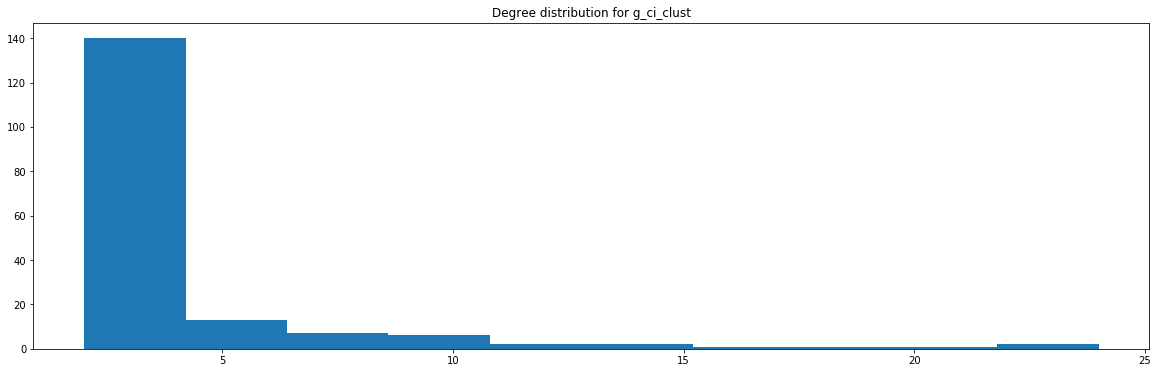

In [76]:
fig, axes = plt.subplots(1, 1, figsize=(20, 6))
axes.set_title('Degree distribution for g_ci_clust')
degrees = [g_ci_clust.degree(n) for n in g_ci_clust.nodes()]
axes.hist(degrees);

Comment on the similarities of your match.

**Your answer here:**

In [74]:
print(f"Network nodes: {g_ci_clust.number_of_nodes():.0f}")
print(f"Network edges: {g_ci_clust.size():.0f}")
print(f"Clustering coefficient: {nx.average_clustering(g_ci_clust):.5f}")

Network nodes: 175
Network edges: 346
Clustering coefficient: 0.08261
